In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Found GPU:", gpu)
else:
    print("No GPU detected")


Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping

import shutil

### Split train and test

In [ ]:
base_dir = "C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00"

real_dir = os.path.join(base_dir, 'real')
fake_dir = os.path.join(base_dir, 'fake')

real_frames = os.path.join(real_dir, "real_frames")
fake_frames = os.path.join(fake_dir, "fake_frames")

real_faces = os.path.join(real_dir, "real_faces")
fake_faces = os.path.join(fake_dir, "fake_faces")

real_faces_dir = os.path.join(real_dir, "real_faces")
fake_faces_dir = os.path.join(fake_dir, "fake_faces")

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# Creating directories for the split dataset
train_real_dir = os.path.join(train_dir, 'real_train')
train_fake_dir = os.path.join(train_dir, 'fake_train')
test_real_dir = os.path.join(test_dir, 'real_test')
test_fake_dir = os.path.join(test_dir, 'fake_test')
os.makedirs(train_real_dir, exist_ok=True)
os.makedirs(train_fake_dir, exist_ok=True)
os.makedirs(test_real_dir, exist_ok=True)
os.makedirs(test_fake_dir, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(source_dir, train_dir, test_dir, test_size=0.2):
    files = [file for file in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, file))]
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), train_dir)

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), test_dir)

if os.path.exists(test_real_dir) and len(os.listdir(test_real_dir)) > 0:
    print("Directory contains files.")
else:
    print("Directory either does not exist or is empty.")
    split_and_copy_files(real_faces_dir, train_real_dir, test_real_dir)
    split_and_copy_files(fake_faces_dir, train_fake_dir, test_fake_dir)

Directory contains files.


In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                          shuffle=False)

test_generator = validation_data_generator.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=20,
                                                  class_mode='binary',
                                                              shuffle=False)

Found 10118 images belonging to 2 classes.
Found 2531 images belonging to 2 classes.


In [ ]:
print(sum(train_generator.classes==0))
print(sum(train_generator.classes==1))

5402
4716


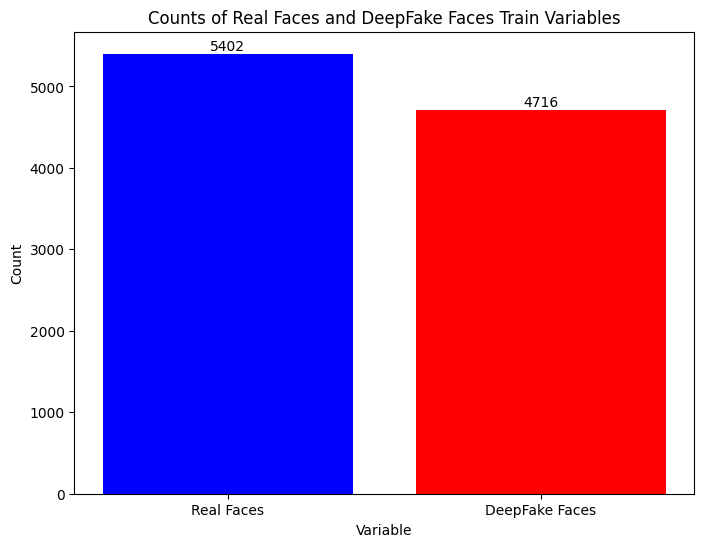

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Real Faces', 'DeepFake Faces']
counts = [sum(train_generator.classes==0), sum(train_generator.classes==1)]

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['blue', 'red'])

# Add labels on top of bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

# Add title and labels
plt.title('Counts of Real Faces and DeepFake Faces Train Variables')
plt.xlabel('Variable')
plt.ylabel('Count')

# Show plot
plt.show()


### Model Creation

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def create_roc_curve(test_generator):
    # Make predictions on the test dataset
    y_pred = model.predict(test_generator)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(test_generator.classes, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    return plt

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(test_generator):
    # Predict the classes for the test data
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Get the true labels for the test data
    y_true = test_generator.classes

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    return plt

In [ ]:
def create_model(learning_rate=0.001, optimizer='adam'):
    vggModel = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    # Freezing the layers of the model to keep the weights of the model fixed while training only the newly added layers on the top
    for layers in vggModel.layers:
        layers.trainable = False

    x = vggModel.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=vggModel.input, outputs=predictions)
    model.summary()
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [ ]:
from sklearn.metrics import classification_report

def create_classification_report(test_generator):
    # Get the model predictions on the test data
    y_pred = model.predict(test_generator)

    # Convert the predicted probabilities to class labels (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Get the true labels from the test data generator
    y_true = test_generator.classes

    return classification_report(y_true, y_pred_binary)

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import scipy

with tf.device("/GPU:0"):
    batch_size = 32
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n//32,
        epochs=20,
        validation_steps=test_generator.n//32,
        validation_data=test_generator,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

Epoch 1/20
316/316 [==============================] - 77s 230ms/step - loss: 0.7356 - accuracy: 0.5780 - val_loss: 0.4530 - val_accuracy: 0.8392
Epoch 2/20
316/316 [==============================] - 70s 222ms/step - loss: 0.6811 - accuracy: 0.6003 - val_loss: 0.5372 - val_accuracy: 0.7797
Epoch 3/20
316/316 [==============================] - 70s 223ms/step - loss: 0.6789 - accuracy: 0.5902 - val_loss: 0.6623 - val_accuracy: 0.6962
Epoch 4/20
316/316 [==============================] - 71s 224ms/step - loss: 0.6471 - accuracy: 0.6312 - val_loss: 0.5862 - val_accuracy: 0.7430


In [ ]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/VggNet16.h5")

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


127/127 [==============================] - 10s 81ms/step - loss: 0.7020 - accuracy: 0.5970
Test Accuracy: 0.5969972610473633, Test Loss: 0.7020116448402405


127/127 [==============================] - 9s 68ms/step


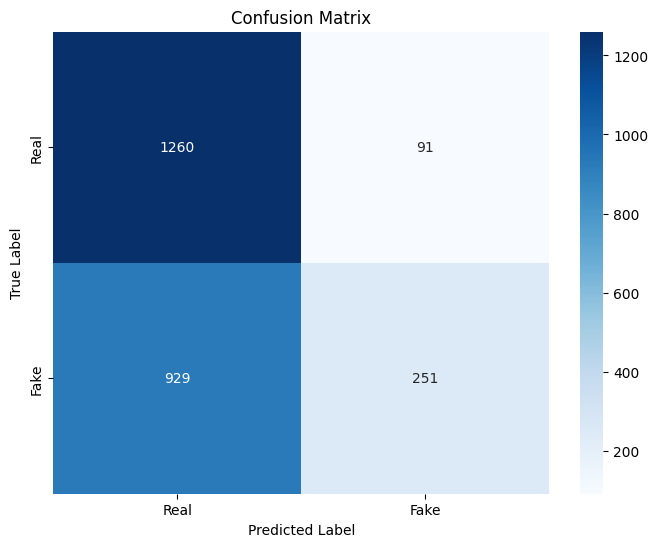

In [ ]:
create_confusion_matrix(test_generator).show()

127/127 [==============================] - 9s 68ms/step


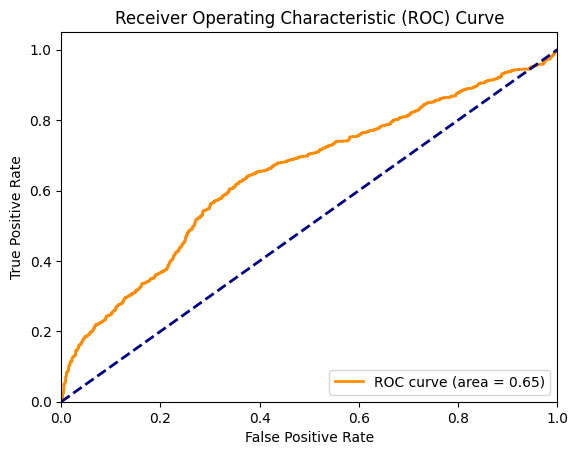

In [ ]:
create_roc_curve(test_generator).show()

In [ ]:
print(create_classification_report(test_generator))

127/127 [==============================] - 9s 68ms/step
              precision    recall  f1-score   support

           0       0.58      0.93      0.71      1351
           1       0.73      0.21      0.33      1180

    accuracy                           0.60      2531
   macro avg       0.65      0.57      0.52      2531
weighted avg       0.65      0.60      0.53      2531



### Adding weights to the model for biasing

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = np.unique(train_generator.classes)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(class_labels),
                                        y = class_labels
                                    )
class_weights = dict(zip(np.unique(class_labels), class_weights))
class_weights

# Create and compile the model with class weights
def create_model_with_class_weights(learning_rate=0.001, optimizer='adam'):
    vggModel = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    # Freezing the layers of the model to keep the weights of the model fixed while training only the newly added layers on the top
    for layers in vggModel.layers:
        layers.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=vggModel.input, outputs=predictions)
    model.summary()
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  class_weight=class_weights_dict)  # Pass class weights here
    return model

# Train the model with class weights
with tf.device("/GPU:0"):
    batch_size = 32
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        epochs=20,
        validation_steps=test_generator.n//batch_size,
        validation_data=test_generator,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

Epoch 1/20
316/316 [==============================] - 71s 223ms/step - loss: 0.6947 - accuracy: 0.5807 - val_loss: 0.8148 - val_accuracy: 0.2981
Epoch 2/20
316/316 [==============================] - 71s 223ms/step - loss: 0.6607 - accuracy: 0.5953 - val_loss: 0.8944 - val_accuracy: 0.1715
Epoch 3/20
316/316 [==============================] - 71s 224ms/step - loss: 0.6531 - accuracy: 0.6304 - val_loss: 0.7151 - val_accuracy: 0.6557
Epoch 4/20
316/316 [==============================] - 71s 223ms/step - loss: 0.6526 - accuracy: 0.6287 - val_loss: 0.5249 - val_accuracy: 0.8234
Epoch 5/20
316/316 [==============================] - 71s 223ms/step - loss: 0.6548 - accuracy: 0.6186 - val_loss: 0.5916 - val_accuracy: 0.7525
Epoch 6/20
316/316 [==============================] - 70s 223ms/step - loss: 0.6376 - accuracy: 0.6491 - val_loss: 0.6702 - val_accuracy: 0.6848
Epoch 7/20
316/316 [==============================] - 70s 223ms/step - loss: 0.6171 - accuracy: 0.6538 - val_loss: 0.4401 - val_ac

In [ ]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/VggNet_Weighted.h5")

127/127 [==============================] - 9s 69ms/step


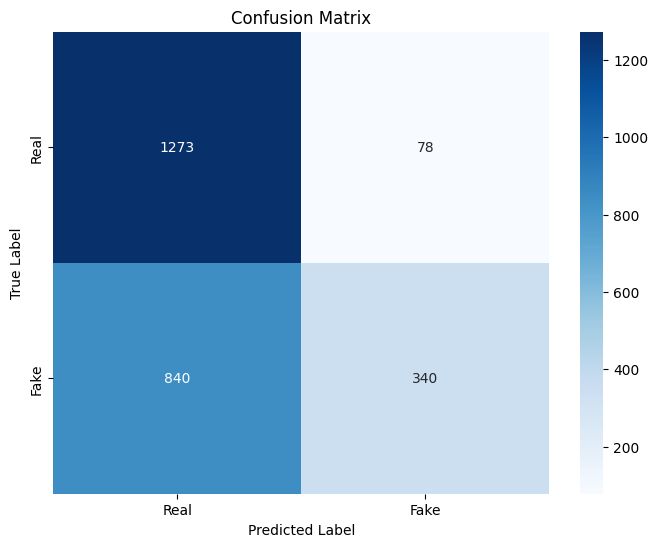

In [ ]:
create_confusion_matrix(test_generator).show()

127/127 [==============================] - 9s 69ms/step


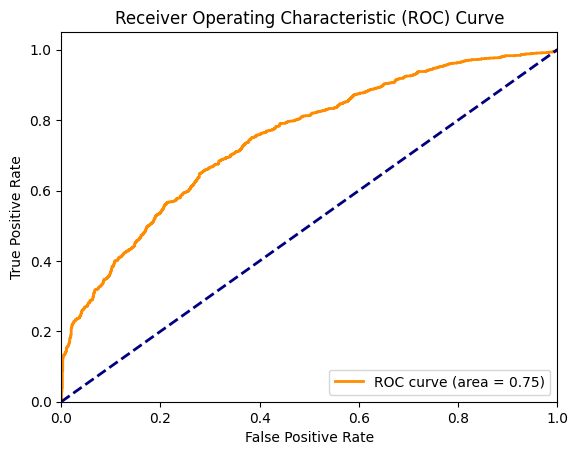

In [ ]:
create_roc_curve(test_generator).show()

In [ ]:
print(create_classification_report(test_generator))

127/127 [==============================] - 9s 69ms/step
              precision    recall  f1-score   support

           0       0.60      0.94      0.73      1351
           1       0.81      0.29      0.43      1180

    accuracy                           0.64      2531
   macro avg       0.71      0.62      0.58      2531
weighted avg       0.70      0.64      0.59      2531



In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


127/127 [==============================] - 9s 72ms/step - loss: 0.6323 - accuracy: 0.6373
Test Accuracy: 0.637297511100769, Test Loss: 0.6323142051696777


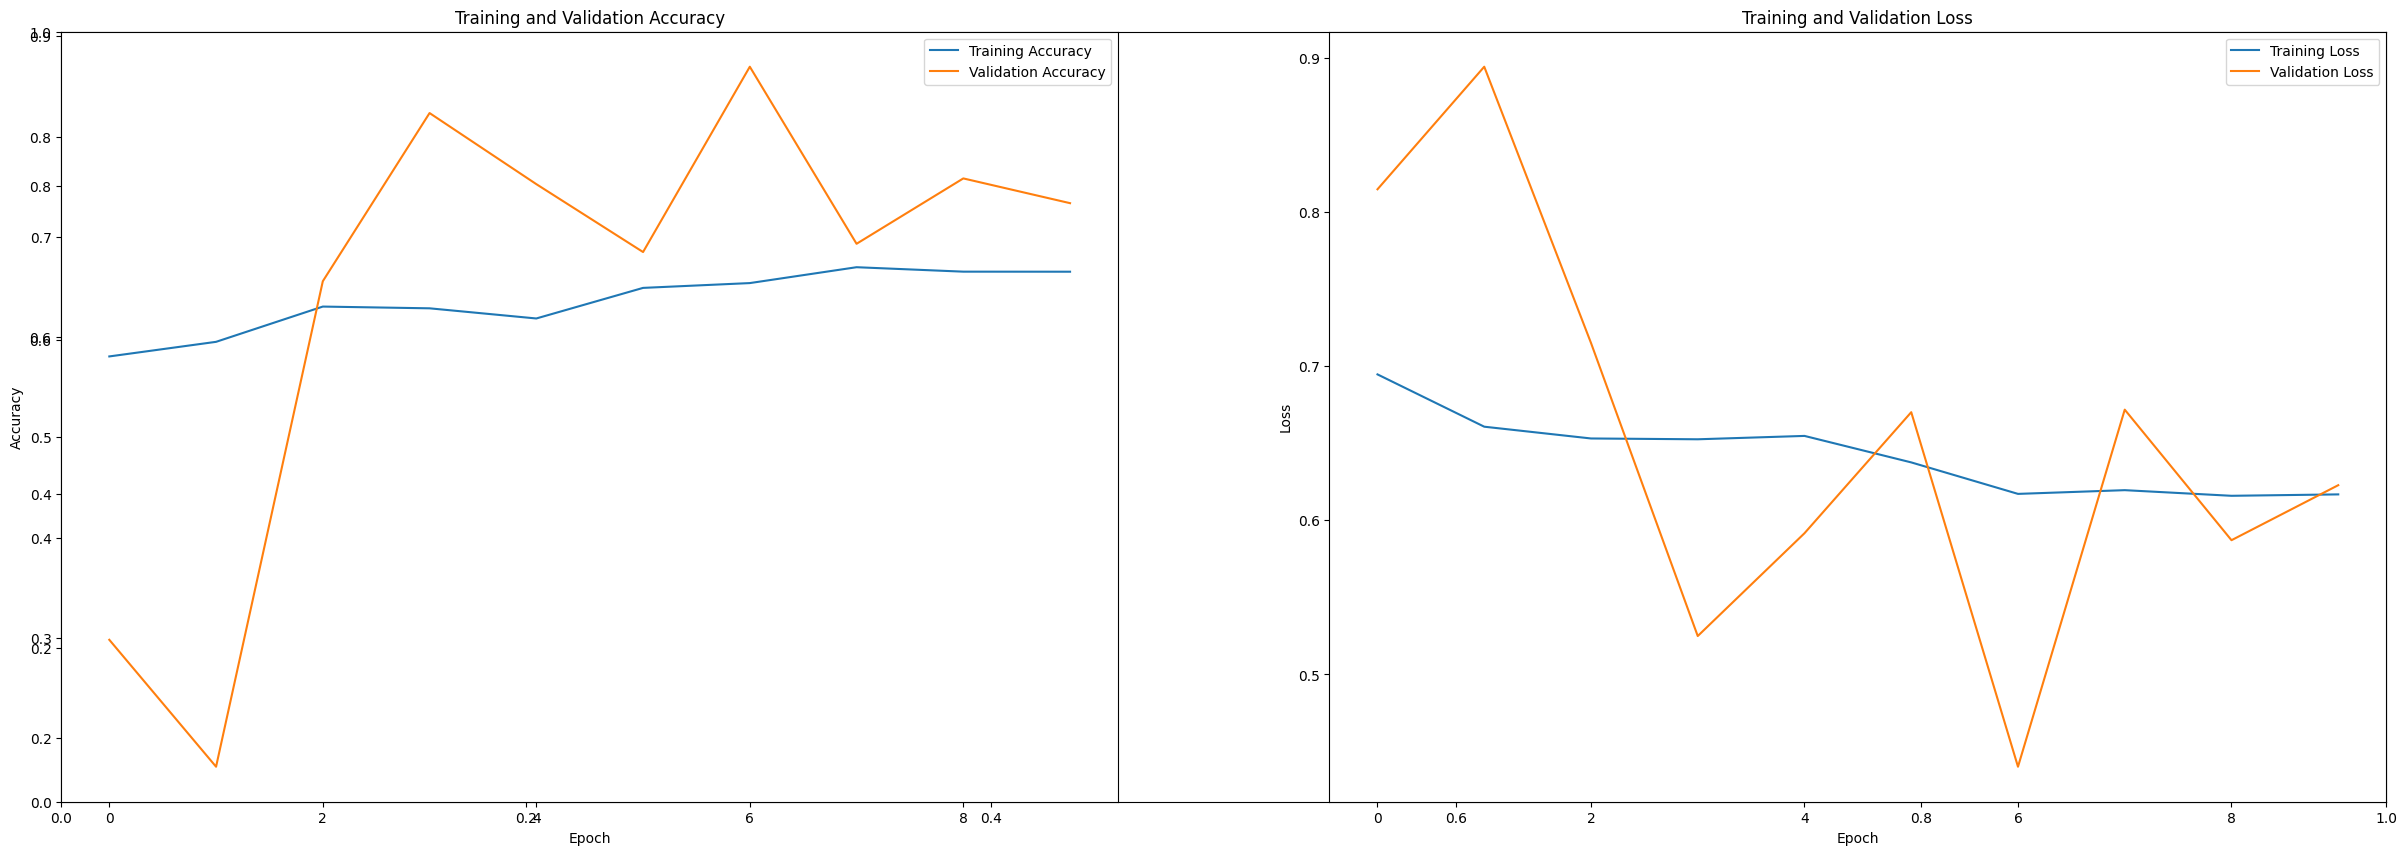

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()